In [1]:
import pandas as pd
import numpy as np
# preprocessing
from sklearn import preprocessing

# K-Means de Sklearn
from sklearn.cluster import KMeans



from sklearn.metrics.cluster import adjusted_rand_score

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



In [3]:
df_data = pd.read_csv("OLIST_data_exploratoire_bis.csv")
df_data.head()

/Applications/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,customer_unique_id,recency,frequency,monetary,average_purchase,min_purchase,max_purchase,nb_item_per_customer,nb_cde_per_customer,average_review_score,min_review_score,max_review_score,payment_type,nb_payment,customer_city,customer_state,deadline_order,purchase_day,purchase_month,purchase_hour,product_category_name,longeur_du_commentaire,last_purchase
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90,129.90,129.90,129.90,1,1,5.0,5.0,5.0,credit_card,8.0,cajamar,SP,6 days 09:52:10,3,5,10,"Home,Furniture",111.0,2017-10-02 10:56:33
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19,18.90,18.90,18.90,1,1,4.0,4.0,4.0,credit_card,1.0,osasco,SP,3 days 06:51:15,0,5,11,"Beauty,Health,Personal Care",8.0,2017-10-02 10:56:33
2,0000f46a3911fa3c0805444483337064,537,1,86.22,69.00,69.00,69.00,1,1,3.0,3.0,3.0,credit_card,8.0,sao jose,SC,25 days 17:33:44,4,3,21,"Home,Furniture",8.0,2017-10-02 10:56:33
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62,25.99,25.99,25.99,1,1,4.0,4.0,4.0,credit_card,4.0,belem,PA,20 days 00:53:24,3,10,20,"Technologie, construction",12.0,2018-07-24 20:41:37
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89,180.00,180.00,180.00,1,1,5.0,5.0,5.0,credit_card,6.0,sorocaba,SP,13 days 03:23:14,1,11,19,"Technologie, construction",8.0,2018-08-08 08:38:49


In [4]:
df_data = df_data.drop(['customer_unique_id','payment_type','customer_city','customer_state','deadline_order','product_category_name'], axis = 1)



In [5]:
df_data['last_purchase'] = df_data['last_purchase'].astype('datetime64[ns]')

In [6]:
total_months = round((df_data['last_purchase'].max() - df_data['last_purchase'].min())/ np.timedelta64(1,'M'))

total_months

20

In [7]:
df_data['last_purchase'].min()

Timestamp('2017-01-05 13:43:17')

In [8]:
df_data['last_purchase'].max()

Timestamp('2018-08-28 21:56:12')

In [9]:
#data_first_year = df_data[df_data['last_purchase'] < pd.to_datetime('2018-01-05')]
data_first_year = df_data[df_data['last_purchase'] < pd.to_datetime('2017-07-05')]
data_first_year = data_first_year.drop(['last_purchase'], axis=1)
data_first_year_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(data_first_year), columns=data_first_year.columns, index=data_first_year.index)




In [10]:
kmeans_maintenance = KMeans(init='k-means++', n_clusters=3, n_init=10, random_state=42)
kmeans_maintenance.fit(data_first_year_scaled)
print(kmeans_maintenance.fit(data_first_year_scaled).labels_)

[1 1 1 ... 1 0 0]


In [11]:
periods = [
    '2017-07-05',
    '2017-08-05',
    '2017-09-05',
    '2017-10-05',
    '2017-11-05',
    '2018-12-05',
  
]

In [12]:
df_scores = []

length = len(kmeans_maintenance.labels_)-1

for i in range(len(periods)):
    scores = {}
    df = df_data[df_data['last_purchase'] < pd.to_datetime(periods[i])]
    df = df.drop(['last_purchase'], axis=1)
    #df_pourcentage = round((df.shape[0] / df_data.shape[0] * 100), 2)
    df_scaled = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df),
                             columns=df.columns,
                             index=df.index)
    kmeans_model = KMeans(init='k-means++', n_clusters=3, n_init=10, random_state=42)
    kmeans_model.fit(data_first_year_scaled)
    clusters_before = kmeans_model.predict(df_scaled)
    model_fit_df = kmeans_model.fit(df_scaled)
    clusters_after = model_fit_df.predict(df_scaled)
    ari_score = round(adjusted_rand_score(
        clusters_before[0:length],
        clusters_after[0:length]),2)
    #scores['df_pourcentage'] = df_pourcentage
    scores['period'] = 'après ' + str(i+1) + ' mois'
    #scores['period'] = 'a partir ' + str(i+2) + ' mois'
    scores['ari_score'] = ari_score
    df_scores.append(scores)
    print(ari_score)

1.0
0.94
0.94
0.72
0.7
0.94


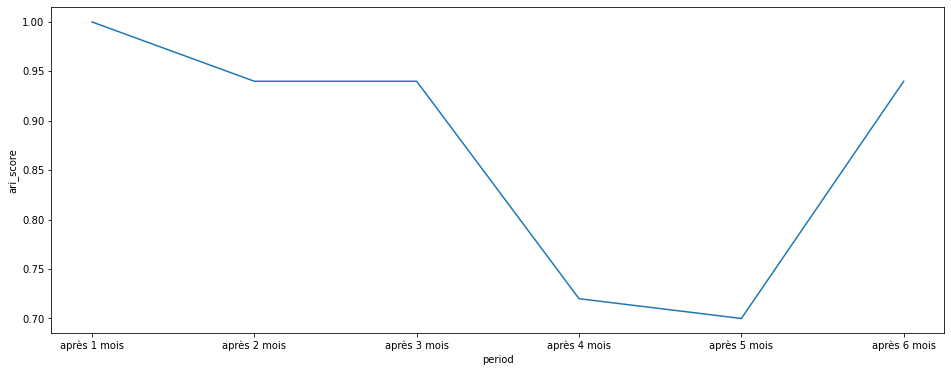

In [13]:
import matplotlib.pyplot as plt
import seaborn as sn
fig = plt.figure(figsize=(16, 6))

bp = sn.lineplot(
    y='ari_score',
    x='period',
    data=pd.DataFrame(
    df_scores,
    columns=['period', 'ari_score'],
),
    #saturation=0.9,
    # order=order,
    # color='darkred',
    ci=None)

for p in bp.patches:
    bp.annotate(format(p.get_height(), '.1f'),
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center',
                va='center',
                xytext=(0, 8),
                textcoords='offset points')
plt.show()